# Execution of the verifiers on the dataset

##### Imports

In [7]:

from collections import defaultdict
from vif.baselines.models import VerEvaluation
from vif.baselines.verifiers_baseline.ver_baseline import TexVerBaseline
from datasets.formatting.formatting import LazyBatch
from PIL import Image
import sys
from datasets import load_dataset, Dataset, load_from_disk,concatenate_datasets
from loguru import logger

from vif.utils.renderer.tex_renderer import TexRenderer
import openai
import os
from google import genai
from google.genai import types as genTypes
from vif.baselines.verifiers_baseline import (
    FalconVerifier,
    TextVerifier,
    TextVisualVerifier,
    ViperGPTVerifier,
    VisualPropertiesVerifier,
    VisualVerifier,
    VisualCodeVerifier,
    PicoBananaVerifier,
    ClipSimVerifier
)
from tqdm import tqdm

logger.remove()
logger.add(tqdm.write)

3

#### Config

In [8]:

NUM_PROC = 1
client = openai.Client(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ.get("OPENROUTER_API_KEY"),
)

gclient = genai.Client(
        api_key=os.environ.get("GOOGLE_API_KEY"),
        http_options=genTypes.HttpOptions(api_version="v1alpha"),
    )

used_model = "qwen/qwen3-vl-8b-instruct"

logger.configure(handlers=[{"sink": sys.stdout, "level": "WARNING"}])
ds = load_dataset("CharlyR/VeriTikz", "full", split="train")
ds = ds.select(range(0,25))
ds_path = "notebooks/verifier_execution/datasets/"
ds_local_name = input("dataset_local_name")


## Execution Code

In [ ]:
renderer = TexRenderer()


def execute_verifier_on_dataset(verifier: TexVerBaseline, dataset: Dataset, n=1):
    metadata = verifier.get_config_metadata()

    def exec_verif(row: LazyBatch, indice: int):
        ver_eval_input: VerEvaluation = VerEvaluation(
            id=row["id"][0],
            approach_name=metadata["name"],
            config_metadata=metadata,
            initial_code=row["code"][0],
            initial_image=row["original_image"][0],
            initial_instruction=row["instruction"][0],
            initial_solution=row["solution"][0],
            initial_solution_image=row["solution_image"][0],
            expected=row["expected"][0],
            theoretical_perfect_image=row["theoretical_perfect_image"][0],
        )
        results: list[VerEvaluation] = []
        for _ in range(n):
            res = verifier.assess_customization(ver_eval_input)

            results.append(res)

        new_rows = defaultdict(list)
        for i, ver_result in enumerate(results):
            res_dict = ver_result.model_dump()
            for key, value in res_dict.items():
                if key == "errors":  # this dict can change, converting to string
                    new_rows[key].append(str(value))
                else:
                    new_rows[key].append(value)
            new_rows["try"].append(i)
            new_rows["index"].append(indice[0])
        return new_rows

    """ if metadata["name"] in os.listdir(ds_path):
        logger.
        computed_dataset = load_from_disk(os.path.join(ds_path,metadata["name"]))
        #keeping only the non-computed instances of the ds
        ds_to_compute = dataset.select(range(len(computed_dataset),len(dataset)+1))
    else:
        ds_to_compute =dataset """

    # sharding with cache
    num_shards = 20 if len(dataset) > 20 else 1
    logger.info("number of shards for ds")

    executed_shards = []
    for ds_shard_index in tqdm(
        range(num_shards), f"Executing {metadata["name"]} on the dataset", unit="shards"
    ):
        ds_shard = ds.shard(num_shards=num_shards, index=ds_shard_index)
        executed_shards.append(
            ds_shard.map(
                exec_verif,
                num_proc=NUM_PROC,
                batched=True,
                batch_size=1,
                remove_columns=dataset.column_names,
                load_from_cache_file=True,
                cache_file_name=os.path.join(
                    ds_path, ds_local_name, metadata["name"], f"shard_{ds_shard_index}"
                ),
            )
        )

    return concatenate_datasets(executed_shards)

## Verifiers execution

#### Config

In [10]:
text_verifier: TexVerBaseline = TextVerifier(
    model=used_model, temperature=0.5, client=client
)

visual_verifier: TexVerBaseline = VisualVerifier(
    model=used_model,
    temperature=0.5,
    client=client
)

text_visual_verifier: TexVerBaseline = TextVisualVerifier(
    model=used_model,
    temperature=0.5,
    client=client
)

text_visual_code_verifier: TexVerBaseline = VisualCodeVerifier(
    model="openai/gpt-5-mini",
    temperature=0.5,
    client=client
)

visual_property_verifier: TexVerBaseline = VisualPropertiesVerifier(
    model=used_model,
    temperature=0.5,
    client=client
)

#full config available here in config file vif/baselines/verifiers_baseline/ViperGPT_adapt/ViperGPT_config.py
vipergpt_verifier: TexVerBaseline = ViperGPTVerifier(
    model=used_model,
    temperature=0.5,
    client=client
)


#full config available here in config file vif/baselines/verifiers_baseline/ViperGPT_adapt/ViperGPT_config.py
clipsim_verifier: TexVerBaseline = ClipSimVerifier()


pico_verifier: TexVerBaseline = PicoBananaVerifier(
    model=used_model,
    temperature=0.5,
    client=client
)


falcon_verifier: TexVerBaseline = FalconVerifier(
    oracle_gen_model=used_model,
    oracle_gen_model_temperature=0.5,
    box_model="gemini-2.0-flash",
    segmentation_model="gemini-2.5-flash",
    property_model=used_model,
    property_model_temperature=0.5,
    gclient=gclient,
    oclient=client,
)

#### Execution

In [26]:
verifiers_to_execute = [
    text_verifier,
    visual_verifier,
    text_visual_verifier,
    #text_visual_code_verifier,
    visual_property_verifier,
    #vipergpt_verifier,
    pico_verifier,
    clipsim_verifier,
    #falcon_verifier,
]
resulting_ds = []

for verifier in verifiers_to_execute:
    current_verif_result_ds = execute_verifier_on_dataset(verifier, ds)
    resulting_ds.append(current_verif_result_ds)

Executing TextVerifier on the dataset:   0%|          | 0/20 [00:00<?, ?shards/s]

Executing PicoBananaVerifier on the dataset:  15%|█▌        | 3/20 [02:02<11:33, 40.78s/shards]


TypeError: Couldn't cast array of type double to null

## Concat and save data locally

In [27]:
from datasets import Dataset,concatenate_datasets

#from time import gmtime, strftime
#cur_time = strftime("%Y-%m-%d-%H-ds_conc", gmtime())
conc_dss:Dataset = concatenate_datasets(resulting_ds)
conc_dss.save_to_disk(os.path.join(ds_path,ds_local_name,"full_ds"))

Saving the dataset (1/1 shards): 100%|██████████| 100/100 [00:00<00:00, 208.88 examples/s]


### Debugging code

#### visual verifier

'{\'base\': [\'{"messages": [{"role": "system", "content": "\\\\nYou are a verification agent, your task is to assess whether a given customization instruction has been applied on a image or not.\\\\nYou will be given the initial and customized images and the instruction.\\\\n\\\\nYour response must always contain the final answer in the format:\\\\n\\\\\\\\boxed{True} or \\\\\\\\boxed{False}\\\\n\\\\nAnswer with True when the instruction is perfectly applied, False when it is not.\\\\n"}, {"role": "user", "content": [{"type": "text", "text": "\\\\nINSTRUCTION:\\\\nMake the body of the bee longer, and pointy\\\\n"}, {"type": "image_url", "image_url": {"url": ""}}]}], "wrapped_exception": "Error code: 404 - {\\\'error\\\': {\\\'message\\\': \\\'No endpoints found for qwen/qwen3-vl-32b-instruct.\\\', \\\'code\\\': 404}, \\\'user_id\\\': \\\'user_2ywjrLszbgj1SGmt3xI9FRMZvaY\\\'}", "name": "RequestException"}\']}'
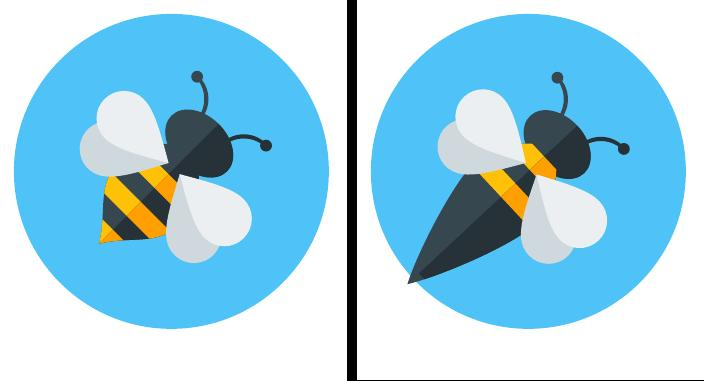

In [23]:
verifier_visual_ds.to_pandas()["errors"][0]

#### visual code verifier

In [19]:
print(verifier_visual_code_ds["errors"][1])

NameError: name 'verifier_visual_code_ds' is not defined

In [12]:
import json
loaded_wrapped = json.loads(verifier_visual_code_ds["errors"][1]["final_request"][0])
json.dumps(loaded_wrapped, indent=4, sort_keys=True)


'{\n    "code": "from PIL import Image\\nimport cv2\\nimport numpy as np\\n\\ndef verify_customization(initial_image, customized_image):\\n    \\"\\"\\"\\n    Verify whether the coordinate system (small axes/origin circle) moved closer to the red force arrow (F)\\n    in the customized_image compared to the initial_image. Return a dict with computed centroids and distances.\\n    \\"\\"\\"\\n    def find_small_circle_centroid(pil_img):\\n        img = np.array(pil_img.convert(\'RGB\'))\\n        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)\\n        # Invert so dark features become white\\n        _, th = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)\\n        # Morph open to remove noise\\n        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))\\n        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)\\n        # Find contours\\n        contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)\\n        candidates = []\\n        for cnt in co

{'messages': [{'role': 'system', 'content': '\nYou are a verification agent. Your task is to determine whether a given customization instruction has been correctly applied to an image.\nYou will be given the initial and customized images, and the instruction.\nYou have access to a Python code execution tool called eval_code(code).\neval_code takes a string of Python code as input and executes it.\n\n- Within this code, you must define a python function called verify_customization that takes the variables initial_image and customized_image, which are both PIL images, of varying size.\n- This function must return any object, that you will have access as the result of the call.\n- You can use the libraries cv2, PIL, and numpy, which you must import explicitly before using them.\n\nThe function has the following signature:\n```\ndef verify_customization(initial_image, customized_image):\n    ...\n```\n\nYou must create the full function, including imports and signature.\nDo not call the fu
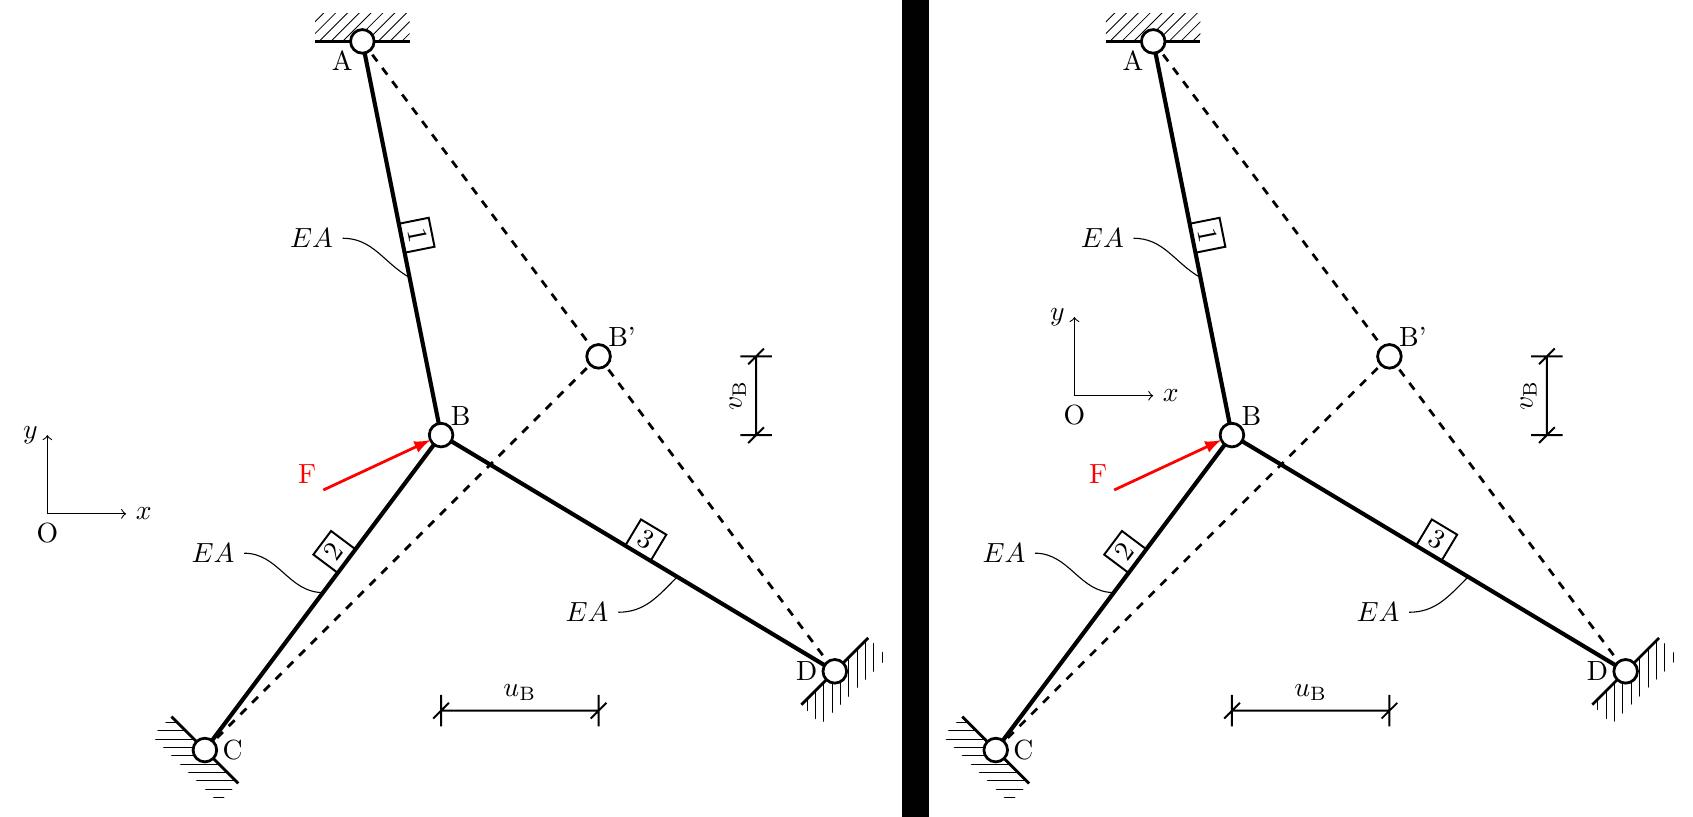

In [ ]:
print(loaded_wrapped["code"])

In [8]:
print(loaded_wrapped["wrapped_exception"])

'tuple' object has no attribute 'sort'


#### property

In [10]:
verifier_visual_property_ds["additional_metadata"]

[{'properties': ['',
   ' Move the origin O of the coordinate system to a point located between the top EA label and the point F, such that the x and y axes are repositioned accordingly.\n',
   ' Ensure the coordinate system remains orthogonal (x',
   'axis horizontal, y',
   'axis vertical) after relocation.\n',
   ' The new origin should lie along the line segment or vicinity between the top EA label and the force vector F, maintaining clarity and avoiding overlap with existing elements.\n',
   " The labels 'x' and 'y' should be clearly visible and oriented correctly relative to the new axes.\n",
   " The position of the coordinate system should not obscure any critical elements like points A, B, C, D, B', or the force F."],
  'properties_eval': [[True, False, True, False, True, False, True, True]]},
 {'properties': ['',
   ' Move the origin O of the coordinate system to a point located between the top EA label and the F force vector.\n',
   ' Ensure the x and y axes are appropriatel

In [ ]:
import json
loaded_wrapped = json.loads(verifier_visual_property_ds["errors"][1]["property_check"][0])

TypeError: the JSON object must be str, bytes or bytearray, not dict

In [ ]:
verifier_visual_property_ds["additional_metadata"]

[{'properties': ['',
   ' The coordinate system (origin O with x and y axes) must be relocated so that it is positioned between the top EA element and the force F vector, specifically in the space directly above point B and below the top EA element, ensuring it is centered horizontally between the top EA and F.\n',
   ' The x and y axes of the coordinate system must remain aligned with the horizontal and vertical directions, respectively, as in the original image.\n',
   ' The origin O of the coordinate system must be moved from its current position at the lower',
   'left corner to a new position between the top EA and the force F, maintaining its orientation.'],
  'properties_eval': [[True, True, True, True, True]]},
 {'properties': ['',
   ' Relocate the origin O of the coordinate system to a position midway between the top of the EA label near point A and the point F (the red arrow) at joint B.\n',
   ' Reorient the x and y axes such that they remain orthogonal and aligned with the

#### concat debug

In [14]:
new_conc_dss.unique("approach_name")

['TextVerifier',
 'VisualVerifier',
 'TextVisualVerifier',
 'VisualPropertyVerifier']

In [ ]:
new_conc_dss['usage_metadata']

In [ ]:
new_conc_dss.column_names